In [1]:
import keras as kr
import numpy as np
import tensorflow as tf
import pandas as pd


Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

In [10]:
data = pd.read_csv("CALQ_output_10x.csv")  ## big  300k file

In [100]:
normData = data.apply(lambda x: x/max(x),axis=1)
#normDataSum = data.apply(lambda x: x/sum(x),axis=1)
inputdata = normData.values

In [124]:
Nsamples = 50000
#inputdata = normData.values[1:Nsamples]
inputdata = normData.values

In [125]:
shaped_data = np.reshape(inputdata,(len(inputdata),12,4,1))

In [126]:
shaped_data.shape

(298458, 12, 4, 1)

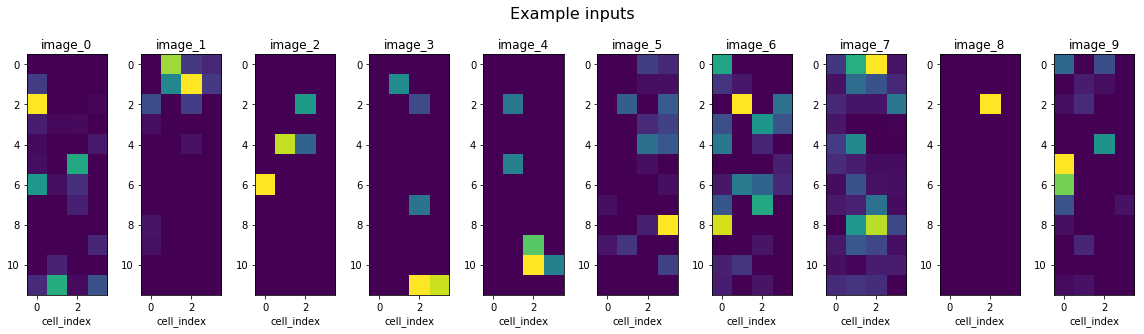

In [127]:
Nevents = 10
index = np.random.choice(shaped_data.shape[0], Nevents, replace=False)  

x = shaped_data[index].reshape(Nevents,12,4)
fig, axs = plt.subplots(1, Nevents, figsize=(16, 5))
fig.suptitle('Example inputs',fontsize=16)
for i in range(0,len(axs)):
    axs[i].set(xlabel='cell_index',title='image_%i'%i)
    c1=axs[i].imshow(x[i])

#plt.colorbar(c1,ax=axs[len(axs)-1])
plt.tight_layout()
plt.show()

In [105]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(12,4,1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [106]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 12, 4, 1)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 4, 16)         160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 2, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 2, 8)           1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 1, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 1, 4)           292       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 1, 4)           0   

In [107]:
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 12, 4, 1)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 4, 16)         160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 2, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 2, 8)           1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 1, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 1, 4)           292       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 1, 4)           0   

In [128]:
validation_frac = 0.2
N = round(len(shaped_data)*validation_frac)

#randomly select 25% entries
index = np.random.choice(shaped_data.shape[0], N, replace=False)  
#select the indices of the other 75%
full_index = np.array(range(0,len(shaped_data)))
train_index = np.logical_not(np.in1d(full_index,index))

val_input = shaped_data[index]
train_input = shaped_data[train_index]

In [129]:
print(train_input.shape)
print(val_input.shape)

(238766, 12, 4, 1)
(59692, 12, 4, 1)


In [132]:
es = kr.callbacks.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = autoencoder.fit(train_input,train_input,
                epochs=150,
                batch_size=500,
                shuffle=True,
                validation_data=(val_input,val_input),
                callbacks=[es])

Train on 238766 samples, validate on 59692 samples
Epoch 1/150
238766/238766 [==============================] - 33s 140us/step - loss: 0.2153 - val_loss: 0.2147
Epoch 2/150
238766/238766 [==============================] - 31s 131us/step - loss: 0.2152 - val_loss: 0.2170
Epoch 3/150
238766/238766 [==============================] - 32s 136us/step - loss: 0.2148 - val_loss: 0.2151
Epoch 4/150
238766/238766 [==============================] - 32s 133us/step - loss: 0.2146 - val_loss: 0.2135
Epoch 5/150
238766/238766 [==============================] - 32s 135us/step - loss: 0.2144 - val_loss: 0.2150
Epoch 6/150
238766/238766 [==============================] - 32s 135us/step - loss: 0.2140 - val_loss: 0.2155
Epoch 7/150
238766/238766 [==============================] - 32s 135us/step - loss: 0.2138 - val_loss: 0.2130
Epoch 8/150
238766/238766 [==============================] - 32s 135us/step - loss: 0.2135 - val_loss: 0.2132
Epoch 9/150
238766/238766 [==============================] - 32s 134u

In [133]:
Layers = 'CNN_16_8_4_full'

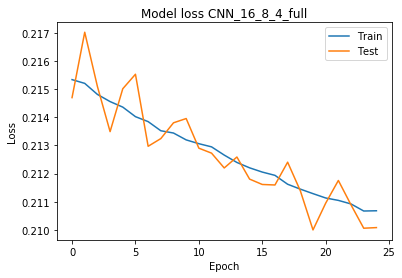

In [134]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss %s'%Layers)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("history_%s.jpg"%Layers)
plt.show()

In [135]:
x = val_input

decoded_Q = autoencoder.predict(x)
encoded_Q = encoder.predict(x)

input_Q   = np.reshape(x,(len(x),12,4))
decoded_Q = np.reshape(decoded_Q,(len(decoded_Q),12,4))
encoded_shape = encoded_Q.shape
encoded_Q = np.reshape(encoded_Q,(len(encoded_Q),encoded_shape[3],encoded_shape[1]))

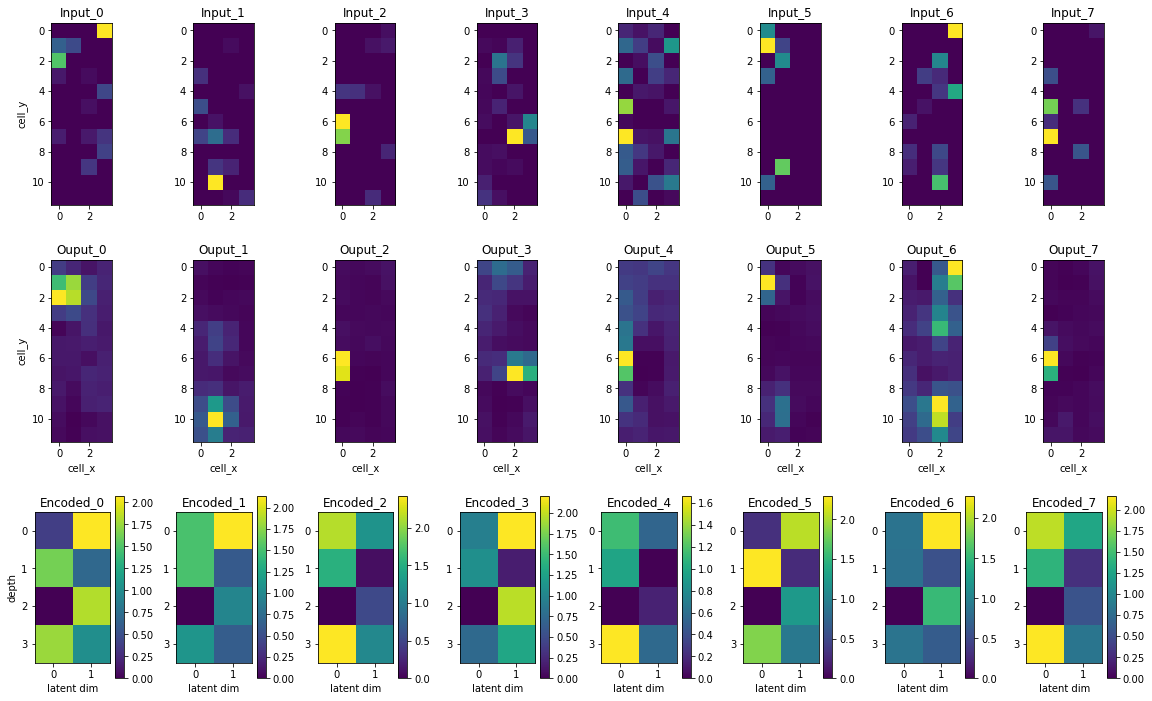

In [136]:

Nevents = 8
index = np.random.choice(x.shape[0], Nevents, replace=False)  

inputImg    = input_Q[index]
encodedImg  = encoded_Q[index]
outputImg   = decoded_Q[index]

fig, axs = plt.subplots(3, Nevents, figsize=(16, 10))

for i in range(0,Nevents):
    if i==0:
        axs[0,i].set(xlabel='',ylabel='cell_y',title='Input_%i'%i)
    else:
        axs[0,i].set(xlabel='',title='Input_%i'%i)        
    c1=axs[0,i].imshow(inputImg[i])
    
for i in range(0,Nevents):
    if i==0:
        axs[1,i].set(xlabel='cell_x',ylabel='cell_y',title='Ouput_%i'%i)        
    else:
        axs[1,i].set(xlabel='cell_x',title='Ouput_%i'%i)
    c1=axs[1,i].imshow(outputImg[i])

for i in range(0,Nevents):
    if i==0:
        axs[2,i].set(xlabel='latent dim',ylabel='depth',title='Encoded_%i'%i)
    else:
        axs[2,i].set(xlabel='latent dim',title='Encoded_%i'%i)
    c1=axs[2,i].imshow(encodedImg[i])
    plt.colorbar(c1,ax=axs[2,i])

plt.tight_layout()
plt.savefig("CNN_eg_%s.jpg"%Layers)

plt.show()

In [61]:
### returns Sum-Squared-Difference of 2 array of images
def SSD(x,y):
    ssd  = np.sum(((decoded_Q-input_Q)**2),(1,2))
    norm = np.sum(decoded_Q**2,(1,2)) *np.sum(input_Q**2,(1,2))
    norm = norm**0.5
    ssd /= norm
    return ssd
def CrossCorrelation(x,y):
    cc  = np.sum(((decoded_Q*input_Q)**2),(1,2))
    norm = np.sum(decoded_Q**2,(1,2)) *np.sum(input_Q**2,(1,2))
    norm = norm**0.5
    cc  /= norm
    return cc

In [73]:
(decoded_Q[1].flatten()*input_Q[1].flatten()).shape

(48,)

In [97]:
def cross_corr(x,y):
    cov = np.cov(x.flatten(),y.flatten())
    std = np.sqrt(np.diag(cov))
    corr = cov / np.multiply.outer(std, std)
    return corr[0,1]

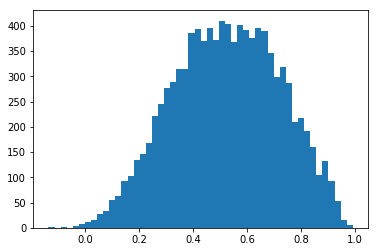

In [119]:
corr = np.array([cross_corr(decoded_Q[i],input_Q[i]) for i in range(0,len(decoded_Q))]).flatten()
plt.hist(corr,50)
plt.show()

In [122]:
np.array(['%.3f'%cross_corr(inputImg[i],outputImg[i]) for i in range(0,len(inputImg))])

array(['0.348', '0.221', '0.562', '0.594', '0.188', '0.717', '0.355',
       '0.449'], dtype='<U5')

In [123]:
cross_corr(inputImg,outputImg)

0.45544794716274895

1.0962029281650378

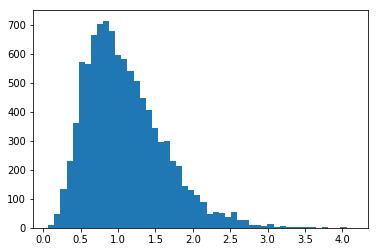

In [118]:
plt.hist(SSD(decoded_Q,input_Q),50)
SSD(decoded_Q,input_Q).mean()

/Users/kakwok/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


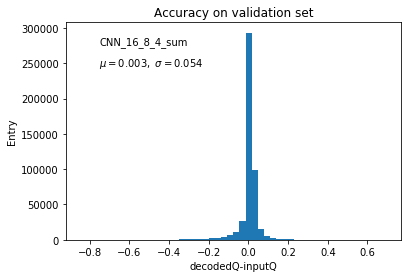

mu=0.003 S.D.= 0.054, ave(PSNR) = 36.475  S.D(PSNR) = 8.624


In [27]:
y = (decoded_Q-input_Q).flatten()
mu = np.mean(y)
std = np.std(y)
mse = np.sum((decoded_Q-input_Q)**2,1)/48
PSNR = 10*np.log10(1/mse)

plt.hist(y,50)

ax = plt.axes()
plt.text(0.1, 0.9, Layers,transform=ax.transAxes)
plt.text(0.1, 0.8, r'$\mu=%.3f,\ \sigma=%.3f$'%(mu,std),transform=ax.transAxes)
plt.xlabel('decodedQ-inputQ')
plt.ylabel('Entry')
plt.title('Accuracy on validation set')
plt.savefig("hist_%s.jpg"%Layers)
plt.show()
print('mu=%.3f'%mu,'S.D.= %.3f, ave(PSNR) = %.3f  S.D(PSNR) = %.3f'%(std,PSNR.mean(),PSNR.std()))

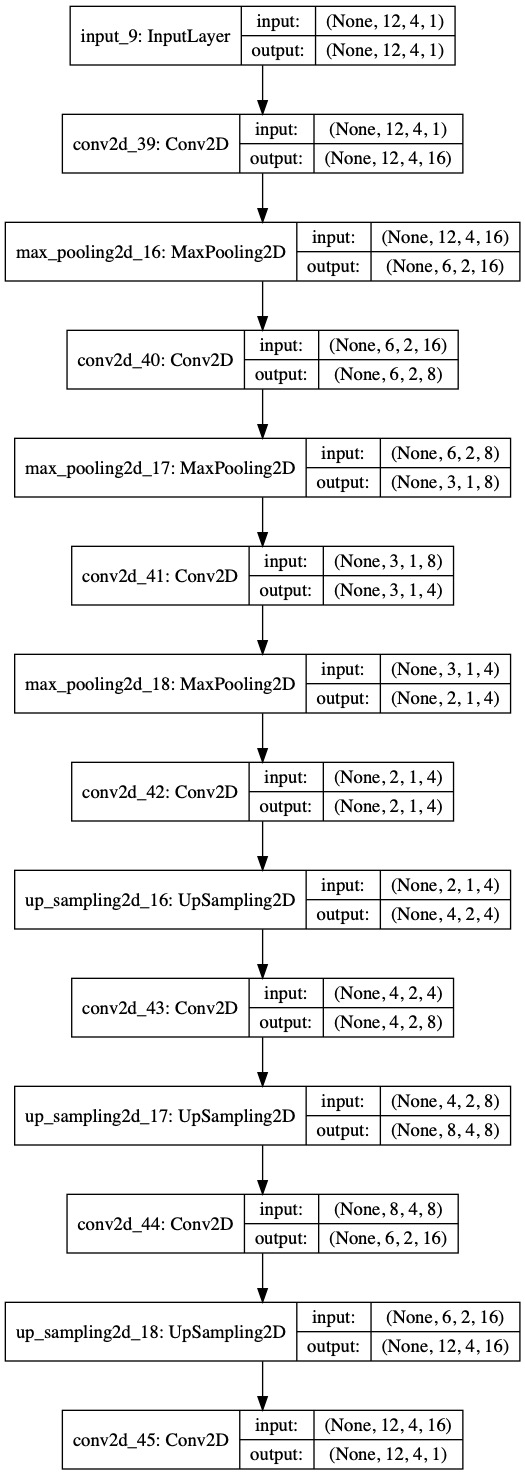

In [186]:
from keras.utils import plot_model
plot_model(autoencoder, show_shapes=True,to_file='model_cnn.jpeg')

In [137]:
from keras.models import model_from_json

json_string = encoder.to_json()
with open('./encoder_model_%s.json'%Layers,'w') as f:
    f.write(json_string)
encoder.save_weights('encoder_%s.hdf5'%Layers)

json_string = autoencoder.to_json()
with open('./autoencoder_model_%s.json'%Layers,'w') as f:
    f.write(json_string)
autoencoder.save_weights('autoencoder_%s.hdf5'%Layers)